# Исследование поведения пользователей на изменение шрифта

## Описание проекта

Работая в стартапе(обучение), который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. Дизайнеры захотели поменять шрифты во всём приложении, но чтобы узнать как скажется на приложении нужно провести тесты и принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

### План задачи

Подключить библиотеки, и отбработать данные

Подготовить и предобработать данные

Изучить и проверить данные

Изучить воронку продаж. 

Изучу результаты эксперимента и провести A/A/B тест

### Описание данных

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# 1 Подготовка данных

In [71]:
#  Подключаю библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math as mth
from scipy import stats as st
import plotly.express as px
import plotly.graph_objects as go

In [72]:
# скачиваем таблицу данных
data = pd.read_csv('/Users/Риндикт/notebook/Новая папка/A-A-B_test_mobile_app_font/logs_exp.csv',sep= "\t")

In [73]:
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Подготовлю и предобработаю данные

In [74]:
# Делаю более понятные названия
data = data.rename(columns = {'EventName':'event','DeviceIDHash':'user_id','EventTimestamp':'event_time','ExpId':'group'})
data.head(5)

,event,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [75]:
data.event_time	 = pd.to_datetime(data.event_time, unit='s')
data['data'] = pd.to_datetime(data.event_time).dt.round('1D')
data.head(5)

,event,user_id,event_time,group,data
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   data        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [77]:
data.duplicated().sum()

413

In [78]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [79]:
data.isna().sum()

event         0
user_id       0
event_time    0
group         0
data          0
dtype: int64

### Итог

Посмотрел и обработал данные, привел название колонок, а так же дату/время к более читаемому виду, проверил и удалил дубликаты, проверил пропуски

## Изучаю и проверяю данные

### Узнаю сколько всего событий в логе

In [80]:
print('Всего событий в логе:', data.event.count())

Всего событий в логе: 243713


### Узнаю сколько всего пользователей в логе

In [81]:
print('Всего уникальных пользователей в логе', data.user_id	.nunique())

Всего уникальных пользователей в логе 7551


### Узнаю cколько в среднем событий приходится на пользователя

In [82]:
print('В среднем на пользователя приходится ', data.event.count() / data.user_id.nunique(),'событий')

В среднем на пользователя приходится  32.27559263673685 событий


### Определяю периуд имеющихся данных

In [83]:
print('Время/дата первого события в наших данных', data.event_time.min())
print('Время/дата последнего события в наших данных', data.event_time.max())

Время/дата первого события в наших данных 2019-07-25 04:43:36
Время/дата последнего события в наших данных 2019-08-07 21:15:17


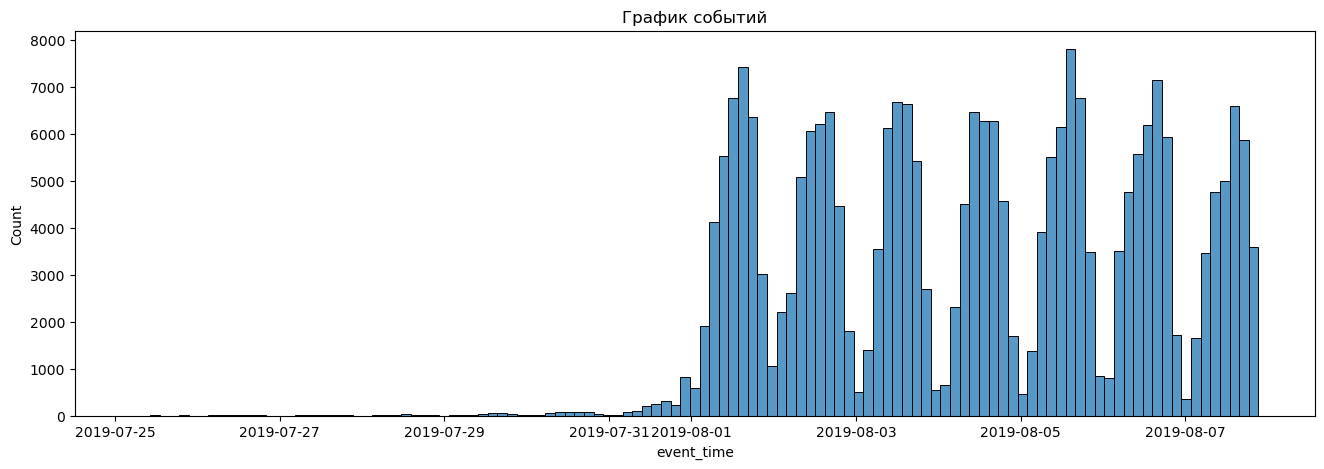

In [84]:
plt.figure(figsize=(16,5))
sns.histplot(data = data, x = 'event_time')
plt.title('График событий')
plt.show()

На графике мы отчетливо видим сезонность и что данные до 1-го числа пользы никакой нам не несут и полноценные данные у нас только за 7 дней

### Убираю не актуальные данные 

In [85]:
actual_data = data.query('data >= "2019-08-01"')

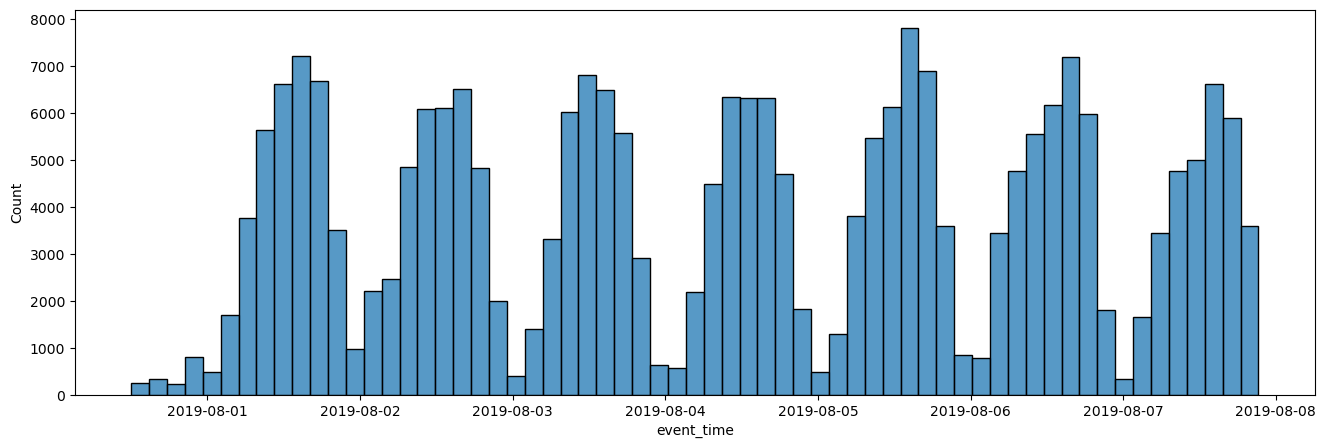

In [86]:
plt.figure(figsize=(16,5))
sns.histplot(data = actual_data, x = 'event_time')
plt.show()

Всё так же видим сезонность и судя по всему ночью совершают мало действий в нашем приложении

### Проверяю много ли событий и пользователей мы потеряли, отбросив старые данные

In [87]:
data_funnel = data.event.value_counts()
data_funnel

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

In [88]:
print('Событий было: ', data.shape[0])
print('Пользователей было: ',data['user_id'].nunique())
print('Событий после того как отбросили данные: ', actual_data.shape[0])
print('Пользователей после того как отбросили данные: ',actual_data['user_id'].nunique())
print('Изменение количества событий: ''{:.1%}'.format((actual_data.shape[0]-data.shape[0])/data.shape[0]))
print('Изменение количества пользователей: ''{:.1%}'.format((actual_data['user_id'].nunique()-data['user_id'].nunique())/data['user_id'].nunique()))

Событий было:  243713
Пользователей было:  7551
Событий после того как отбросили данные:  242554
Пользователей после того как отбросили данные:  7542
Изменение количества событий: -0.5%
Изменение количества пользователей: -0.1%


### Проверю, что у нас есть пользователи из всех трёх экспериментальных групп.

In [89]:
actual_data.groupby('group')['user_id'].nunique().to_frame()

,user_id
group,
246,2485
247,2517
248,2540


### Итог

Изучил данные, исследование началось 019-07-25 и сколько оно длилось 14 дней до 2019-08-07, убрал не актуальные данные осталась от наблюдений только неделя, проверил наличие пользователей из 3-х тестовых групп

## Изучу воронку событий

In [90]:
actual_data_funnel = actual_data.groupby('event',as_index= False) \
                    .agg({'user_id':'count'}) \
                    .rename(columns = {'count':'count_users'}).sort_values(by = 'user_id', ascending = False)
actual_data_funnel

,event,user_id
1,MainScreenAppear,118320
2,OffersScreenAppear,46667
0,CartScreenAppear,42518
3,PaymentScreenSuccessful,34036
4,Tutorial,1013


У меня есть 5 событий

1) Появление главного экрана

2) Появление экрана предложений

3) Появление экрана корзины

4) Экран оплаты успешно

5) Руководство

Тут видна воронка событий начиная с главного экрана и заканчивая успешной оплатой. Tutorial	я считаю не обязательным эвентом и им пользуются только те кто плохо ориентируется в подобных приложениях, а опытным пользователям оно ни к чему.

In [91]:
def get_event_count(event):
    count_uniq_users = actual_data[actual_data['event']==event]['user_id'].nunique()
    return count_uniq_users

In [92]:
# Убираю Tutorial так как он побочное событие и не влияет на воронку

actual_data_funnel = actual_data_funnel.query('event != "Tutorial"')
actual_data_funnel['uniq_users'] = actual_data_funnel.event.apply(get_event_count)
actual_data_funnel['share_users_nexl_funnel'] = round(actual_data_funnel['uniq_users']/actual_data_funnel['uniq_users'].shift(1),3)
actual_data_funnel['share_of_all'] = actual_data_funnel['uniq_users']/actual_data_funnel['uniq_users'].max()
actual_data_funnel

C:\Users\Риндикт\AppData\Local\Temp\ipykernel_8208\2020809024.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Риндикт\AppData\Local\Temp\ipykernel_8208\2020809024.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Риндикт\AppData\Local\Temp\ipykernel_8208\2020809024.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,event,user_id,uniq_users,share_users_nexl_funnel,share_of_all
1,MainScreenAppear,118320,7429,NaN,1.000000
2,OffersScreenAppear,46667,4603,0.620,0.619599
0,CartScreenAppear,42518,3741,0.813,0.503567
3,PaymentScreenSuccessful,34036,3542,0.947,0.476780


Больше всего пользователей мы теряем на 2ой воронке (переходе с главного экрана на экран предложений) переходят 62%

А доля дошедших от главного экрана до оплаты составляет ~48%

In [93]:
fig = go.Figure(go.Funnel(y = actual_data_funnel['event'],
                          x = actual_data_funnel['uniq_users'],
                          
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title='Воронка от главного экрана до оплаты', title_x = 0.5)
fig.show()

## Изучу результаты эксперимента

### Проверю пересекаются ли пользователи в группах.

In [94]:
actual_data.groupby('group')['user_id'].nunique().to_frame()

group_a = set(actual_data[actual_data["group"] == "246"]["user_id"].unique())
group_aa = set(actual_data[actual_data["group"] == "247"]["user_id"].unique())
large_group_aa = group_a.intersection(group_aa)
print(f'Количество пересекающихся пользователей между группами A и AA: {len(large_group_aa)}')

group_b = set(actual_data[actual_data["group"] == '248']["user_id"].unique())
group_ab = large_group_aa.intersection(group_b)
print(f'Количество пересекающихся пользователей между группами A/АА и B: {len(group_ab)}')

Количество пересекающихся пользователей между группами A и AA: 0
Количество пересекающихся пользователей между группами A/АА и B: 0


### Проверю как пользователи распределены по группам и событиям 

In [95]:
users_by_events = actual_data.pivot_table(index='group', columns='event', values = 'user_id', aggfunc = 'nunique').reset_index()
user_count = actual_data.groupby('group')['user_id'].nunique()
users_by_events['user_count'] = users_by_events['group'].apply(lambda x: user_count.loc[x])
users_by_events

event,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,user_count
0,246,1267,2452,1543,1200,278,2485
1,247,1239,2479,1526,1159,285,2517
2,248,1235,2498,1534,1183,282,2540


Вижу что в по группам пользователи распределены примерно одинаково

### Выберу самое популярное событие. Посчитаю число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаю долю пользователей, совершивших это событие. Проверю, будет ли отличие между группами статистически достоверным. Проделаю то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?

In [96]:
users_by_events
big_aa = users_by_events.apply(lambda x: x.sum(),axis=0)
users_by_events = users_by_events.append(big_aa,ignore_index=True)
users_by_events

C:\Users\Риндикт\AppData\Local\Temp\ipykernel_8208\3036587575.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



event,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,user_count
0,246,1267,2452,1543,1200,278,2485
1,247,1239,2479,1526,1159,285,2517
2,248,1235,2498,1534,1183,282,2540
3,741,3741,7429,4603,3542,845,7542


In [97]:
def check(a, b, list_col):
    
    print('Сравниваем группы:', a.group, b.group)
    for i in list_col:
        print()
        print('Проверим, будет ли отличие между группами в воронке {} статистически достоверным'.format(i))
        print()
        alpha = 0.01/len(list_col)
        one = np.array([a[i],b[i]])
        user_count = np.array([a['user_count'],b['user_count']])
        
        p1 = one[0]/user_count[0]
        p2 = one[1]/user_count[1]
        
        p_combined = (one[0]+one[1])/(user_count[0]+user_count[1])
        
        difference = p1-p2
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/user_count[0] + 1/user_count[1]))
        
        distr = st.norm(0, 1)  
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаю нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
                 ) 


### Сравниваю группы А/АА

In [98]:
list_columns = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']

a_group = users_by_events.query('group == 246')
aa_group = users_by_events.query('group == 247')

check(a_group,aa_group,list_columns)

Сравниваем группы: 0    246
Name: group, dtype: int64 1    247
Name: group, dtype: int64

Проверим, будет ли отличие между группами в воронке MainScreenAppear статистически достоверным

p-значение:  [0.58687768]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке OffersScreenAppear статистически достоверным

p-значение:  [0.28743295]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке CartScreenAppear статистически достоверным

p-значение:  [0.21306132]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке PaymentScreenSuccessful статистически достоверным

p-значение:  [0.11210845]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Итог
Мы убидились что группы для А/А-эксперимента статистические не различаются

### Сравнениваю A(246) группы с B(248)

In [99]:
b_group = users_by_events.query('group == 248')

check(a_group, b_group, list_columns)

Сравниваем группы: 0    246
Name: group, dtype: int64 2    248
Name: group, dtype: int64

Проверим, будет ли отличие между группами в воронке MainScreenAppear статистически достоверным

p-значение:  [0.34128639]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке OffersScreenAppear статистически достоверным

p-значение:  [0.21653517]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке CartScreenAppear статистически достоверным

p-значение:  [0.09381753]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке PaymentScreenSuccessful статистически достоверным

p-значение:  [0.22352232]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Итог
Проведя сравнение группа А(246) статистически не отличается от B(248) 

### Сравнение AA(247) группы с B(248)

In [100]:
check(aa_group, b_group, list_columns)

Сравниваем группы: 1    247
Name: group, dtype: int64 2    248
Name: group, dtype: int64

Проверим, будет ли отличие между группами в воронке MainScreenAppear статистически достоверным

p-значение:  [0.68195838]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке OffersScreenAppear статистически достоверным

p-значение:  [0.86483178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке CartScreenAppear статистически достоверным

p-значение:  [0.66787865]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке PaymentScreenSuccessful статистически достоверным

p-значение:  [0.70658947]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Итог
Проведя сравнени АA(247) группа статестически не отлечается от B(248) 

### Сравнение B с объединённой контрольной группой. 

In [101]:
aaa_big_group = users_by_events.query('group == 741')
check(aaa_big_group, b_group, list_columns)

Сравниваем группы: 3    741
Name: group, dtype: int64 2    248
Name: group, dtype: int64

Проверим, будет ли отличие между группами в воронке MainScreenAppear статистически достоверным

p-значение:  [0.58225418]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке OffersScreenAppear статистически достоверным

p-значение:  [0.56887388]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке CartScreenAppear статистически достоверным

p-значение:  [0.39277704]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверим, будет ли отличие между группами в воронке PaymentScreenSuccessful статистически достоверным

p-значение:  [0.73409587]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Итог
Проведя сравнени контрольной группой АAA(741) группа статестически не отлечается от B(248) 

## Общий вывод

Были получены, проверены, подготовлены данные и проведены исследования.

Была построена воронка на которой мы видели как пользователи не доходили, но оплаты.

Проверил что бы данные не пересекались.

Так же я проверил и не нашел статистически значимых различий между группами А/А и после этого сделал A/B тест, а так же с объединённой контрольной групп. Различий выявлено не было, а это значит что гипотеза о том что изменение шрифта повлияет на метрики конверсии не подтвердилась.

Но так как пришлось отсеять данные за неделю у нас осталась только половинна времени изначально планированного исследования, я рекомендовал бы продлить исследования на неделю что бы накопить больше данных хотя я не ожидаю кардинальных изменений учитывая что p_value был довольно высок и не опускался ниже 0.42